In [1]:
!pip install ta


In [2]:

# Libraries for Data Handling and Date/Time Management
import datetime as dt
from datetime import datetime, timezone
import time
import pandas as pd
import numpy as np

# Libraries for Technical Analysis and Financial Indicators
import ta  # Technical Analysis Library

# Libraries for Data Visualization
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Libraries for Fetching Data from the Web
import requests


In [3]:
# --- API Call Function ---
def make_api_call(base_url, endpoint, method, params=None, headers=None):
    """Make API call to Binance"""
    url = base_url + endpoint

    if method == 'GET':
        response = requests.get(url, params=params, headers=headers)
    elif method == 'POST':
        response = requests.post(url, json=params, headers=headers)
    else:
        raise ValueError(f"Unsupported HTTP method: {method}")

    # Check if the request was successful
    if response.status_code != 200:
        raise Exception(f"API call failed: {response.text}")

    return response

# --- Updated Data Retrieval Function ---
def get_binance_historical_data(symbol, interval, start_date, end_date=None):
    """
    Fetch historical price data from Binance Futures API

    Parameters:
    - symbol: trading pair, e.g., 'BTCUSDT'
    - interval: time interval, e.g., '30m', '1h', '1d'
    - start_date: timestamp in milliseconds
    - end_date: timestamp in milliseconds (optional)

    Returns:
    - pandas DataFrame with price data in UTC time
    """
    # define basic parameters for call
    base_url = 'https://fapi.binance.com'
    endpoint = '/fapi/v1/klines'
    method = 'GET'

    # Set the start time parameter in the params dictionary
    params = {
        'symbol': symbol,
        'interval': interval,
        'limit': 1500,
        'startTime': start_date  # Start time in milliseconds
    }

    # Make initial API call to get candles
    response = make_api_call(base_url, endpoint=endpoint, method=method, params=params)

    candles_data = []

    while len(response.json()) > 0:
        new_candles = response.json()
        # Append the received candles to the list
        candles_data.extend(new_candles)

        # Break if we've reached the end date
        if end_date and new_candles[-1][0] >= end_date:
            break

        # Update the start time for the next API call
        params['startTime'] = new_candles[-1][0] + 1  # last candle open_time + 1ms

        # Make the next API call
        response = make_api_call(base_url, endpoint=endpoint, method=method, params=params)

        # Add a small delay to avoid rate limiting
        time.sleep(0.1)

    # If end_date is provided, filter candles to be before or equal to end_date
    if end_date:
        candles_data = [candle for candle in candles_data if candle[0] <= end_date]

    # Wrap the candles data as a pandas DataFrame
    columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume',
               'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']

    dtype = {
        'open_time': 'datetime64[ms]',  # Using UTC time
        'open': 'float64',
        'high': 'float64',
        'low': 'float64',
        'close': 'float64',
        'volume': 'float64',
        'close_time': 'datetime64[ms]',  # Using UTC time
        'quote_asset_volume': 'float64',
        'number_of_trades': 'int64',
        'taker_buy_base_asset_volume': 'float64',
        'taker_buy_quote_asset_volume': 'float64',
        'ignore': 'float64'
    }

    df = pd.DataFrame(candles_data, columns=columns)
    df = df.astype(dtype)

    # Add timestamp column to maintain compatibility with existing code
    df['timestamp'] = df['open_time']

    return df

In [4]:
# --- Technical Indicators ---
def ut_bot_minimal(df, keyValue=3.0, atrPeriod=10):
    """Calculate UT Bot indicator (ATR-based trailing stop)"""
    df = df.copy()
    df.columns = [c.lower() for c in df.columns]
    df['src'] = df['close']

    # Calculate ATR
    df['atr'] = ta.volatility.average_true_range(df['high'], df['low'], df['close'], window=atrPeriod)
    df['nloss'] = keyValue * df['atr']

    n = len(df)
    xATRTrailingStop = [np.nan] * n
    pos = [0] * n
    buy_signal = [False] * n
    sell_signal = [False] * n

    for i in range(n):
        src_i = df['src'].iloc[i]
        nloss_i = df['nloss'].iloc[i]
        if i == 0:
            # Initialize
            xATRTrailingStop[i] = src_i
            pos[i] = 0
        else:
            prev_stop = xATRTrailingStop[i - 1]
            src_i1 = df['src'].iloc[i - 1]

            # Update trailing stop
            if (src_i > prev_stop) and (src_i1 > prev_stop):
                # Uptrend continues
                xATRTrailingStop[i] = max(prev_stop, src_i - nloss_i)
            elif (src_i < prev_stop) and (src_i1 < prev_stop):
                # Downtrend continues
                xATRTrailingStop[i] = min(prev_stop, src_i + nloss_i)
            else:
                # Trend changed
                if src_i > prev_stop:
                    xATRTrailingStop[i] = src_i - nloss_i  # New uptrend
                else:
                    xATRTrailingStop[i] = src_i + nloss_i  # New downtrend

            # Determine position
            if (src_i1 < xATRTrailingStop[i - 1]) and (src_i > xATRTrailingStop[i]):
                pos[i] = 1  # Bullish
            elif (src_i1 > xATRTrailingStop[i - 1]) and (src_i < xATRTrailingStop[i]):
                pos[i] = -1  # Bearish
            else:
                pos[i] = pos[i - 1]  # No change

        # Generate signals
        if i > 0:
            buy_signal[i] = (pos[i] == 1 and pos[i - 1] == -1)
            sell_signal[i] = (pos[i] == -1 and pos[i - 1] == 1)

    # Add calculated values to DataFrame
    df['xATRTrailingStop'] = xATRTrailingStop
    df['pos'] = pos
    df['buy_signal'] = buy_signal
    df['sell_signal'] = sell_signal

    return df

In [5]:
def ema(series, period):
    """Calculate Exponential Moving Average"""
    return series.ewm(span=period, adjust=False).mean()

In [6]:
def compute_stc_shk(df, length=80, fast_length=27, slow_length=50, aaa=0.5, col_close='close'):
    """Calculate Schaff Trend Cycle indicator"""
    df = df.copy()

    # Calculate MACD line
    fastMA = ema(df[col_close], fast_length)
    slowMA = ema(df[col_close], slow_length)
    diffEMA = fastMA - slowMA

    # Initialize arrays
    n = len(df)
    ccccc_vals = np.full(n, np.nan)  # First stochastic
    ddd_vals = np.full(n, np.nan)    # First smoothing
    dddddd_vals = np.full(n, np.nan) # Second stochastic
    eeeee_vals = np.full(n, np.nan)  # Second smoothing (final)

    # Calculate STC values
    for i in range(n):
        if i < length - 1:
            continue

        # First stochastic
        window = diffEMA.iloc[i - length + 1: i + 1]
        lowest_val = window.min()
        highest_val = window.max()
        rng = highest_val - lowest_val

        if rng > 0:
            ccccc_now = (diffEMA.iloc[i] - lowest_val) / rng * 100
        else:
            ccccc_now = ccccc_vals[i - 1] if (i > 0 and not np.isnan(ccccc_vals[i - 1])) else 0
        ccccc_vals[i] = ccccc_now

        # First smoothing
        if i == 0 or np.isnan(ddd_vals[i - 1]):
            ddd_now = ccccc_now
        else:
            ddd_now = ddd_vals[i - 1] + aaa * (ccccc_now - ddd_vals[i - 1])
        ddd_vals[i] = ddd_now

        # Second stochastic
        window_ddd = ddd_vals[i - length + 1: i + 1]
        lowest_ddd = np.nanmin(window_ddd)
        highest_ddd = np.nanmax(window_ddd)
        rng_ddd = highest_ddd - lowest_ddd

        if rng_ddd > 0:
            dddddd_now = (ddd_now - lowest_ddd) / rng_ddd * 100
        else:
            dddddd_now = dddddd_vals[i - 1] if (i > 0 and not np.isnan(dddddd_vals[i - 1])) else 0
        dddddd_vals[i] = dddddd_now

        # Second smoothing (final STC)
        if i == 0 or np.isnan(eeeee_vals[i - 1]):
            eeeee_now = dddddd_now
        else:
            eeeee_now = eeeee_vals[i - 1] + aaa * (dddddd_now - eeeee_vals[i - 1])
        eeeee_vals[i] = eeeee_now

    # Add to DataFrame
    df['stc_shk'] = eeeee_vals
    return df

In [7]:
# --- Trading Strategy ---
def apply_strategy(df, stc_col='stc_shk', green_line=25, red_line=75):
    """Combine UT Bot and STC for trading signals"""
    df = df.copy()
    df['buy_condition'] = False
    df['sell_condition'] = False

    # Create shifted STC for trend detection
    df['stc_shift1'] = df[stc_col].shift(1)

    # Apply conditions for signals
    for i in range(1, len(df)):
        stc_now = df[stc_col].iloc[i]
        stc_prev = df['stc_shift1'].iloc[i]

        if pd.isna(stc_now) or pd.isna(stc_prev):
            continue

        # Buy conditions
        if (df['buy_signal_2'].iloc[i] == True and
            stc_now < green_line and
            stc_now > stc_prev):  # STC rising
            df.loc[df.index[i], 'buy_condition'] = True

        # Sell conditions
        if (df['sell_signal_1'].iloc[i] == True and
            stc_now > red_line and
            stc_now < stc_prev):  # STC falling
            df.loc[df.index[i], 'sell_condition'] = True

    # Calculate stop loss and take profit levels
    df['stop_loss_buy'] = df['low'].shift(1)
    df['distance_buy'] = df['close'] - df['stop_loss_buy']
    df['take_profit_buy'] = df['close'] + 2 * df['distance_buy']

    df['stop_loss_sell'] = df['high'].shift(1)
    df['distance_sell'] = df['stop_loss_sell'] - df['close']
    df['take_profit_sell'] = df['close'] - 2 * df['distance_sell']

    return df

In [8]:
# --- Trade Simulation ---
def simulate_trade_for_signal(df_full, signal_index, signal_type='BUY', lookback=3):
    """Simulate single trade result"""
    idx = signal_index
    if idx < lookback:
        return None

    entry_price = df_full.loc[idx, 'close']

    # Calculate Stop Loss and Take Profit
    if signal_type.upper() == 'BUY':
        stop_loss = df_full.loc[idx - lookback: idx - 1, 'low'].min()
        take_profit = entry_price + 2 * (entry_price - stop_loss)
    else:  # SELL
        stop_loss = df_full.loc[idx - lookback: idx - 1, 'high'].max()
        take_profit = entry_price - 2 * (stop_loss - entry_price)

    exit_price = None
    exit_idx = None

    # Simulate future price action
    for j in df_full.index[df_full.index > idx]:
        high_j = df_full.loc[j, 'high']
        low_j = df_full.loc[j, 'low']

        if signal_type.upper() == 'BUY':
            if high_j >= take_profit:  # TP hit
                exit_price = take_profit
                exit_idx = j
                break
            elif low_j <= stop_loss:  # SL hit
                exit_price = stop_loss
                exit_idx = j
                break
        else:  # SELL
            if low_j <= take_profit:  # TP hit
                exit_price = take_profit
                exit_idx = j
                break
            elif high_j >= stop_loss:  # SL hit
                exit_price = stop_loss
                exit_idx = j
                break

    # If no exit found, close at the last price
    if exit_price is None:
        exit_price = df_full.iloc[-1]['close']
        exit_idx = df_full.index[-1]

    # Calculate return
    if signal_type.upper() == 'BUY':
        return_pct = (exit_price - entry_price) / entry_price * 100
    else:  # SELL
        return_pct = (entry_price - exit_price) / entry_price * 100

    # Return trade details
    return {
        'signal_index': idx,
        'entry_price': entry_price,
        'stop_loss': stop_loss,
        'take_profit': take_profit,
        'exit_price': exit_price,
        'exit_index': exit_idx,
        'return_pct': return_pct,
        'signal_type': signal_type.upper()
    }

In [9]:
def calculate_trades_from_signals(df_full, signals_df, signal_type='BUY', lookback=3):
    """Calculate results for all signals of a type"""
    trades = []
    for idx in signals_df.index:
        trade = simulate_trade_for_signal(df_full, idx, signal_type=signal_type, lookback=lookback)
        if trade is not None:
            trades.append(trade)

    return pd.DataFrame(trades)

In [10]:
# --- Visualization & Analysis ---
def plot_candlestick_with_signals(df_final, buy_signals, sell_signals, title):
    """Create candlestick chart with signals"""
    fig = go.Figure(data=[go.Candlestick(
        x=df_final['timestamp'],
        open=df_final['open'],
        high=df_final['high'],
        low=df_final['low'],
        close=df_final['close'],
        name='Candlesticks'
    )])

    # Add Buy signals
    fig.add_trace(go.Scatter(
        x=buy_signals['timestamp'],
        y=buy_signals['close'],
        mode='markers',
        name='Buy Signal',
        marker=dict(symbol='triangle-up', size=14, color='green')
    ))

    # Add Sell signals
    fig.add_trace(go.Scatter(
        x=sell_signals['timestamp'],
        y=sell_signals['close'],
        mode='markers',
        name='Sell Signal',
        marker=dict(symbol='triangle-down', size=14, color='red')
    ))

    fig.update_layout(
        title=title,
        xaxis_title="Time",
        yaxis_title="Price",
        xaxis_rangeslider_visible=False,
        template="plotly_white"
    )

    return fig


In [11]:
def plot_portfolio_value(trades_df, df_full, initial_value=100, title="Cumulative Portfolio Value"):
    """Plot portfolio equity curve"""
    if trades_df.empty:
        print("No trades to plot portfolio value.")
        return

    trades_df = trades_df.copy()
    # Add timestamp to trades
    trades_df['timestamp'] = df_full.loc[trades_df['signal_index'], 'timestamp'].values
    trades_df.sort_values('timestamp', inplace=True)

    # Calculate cumulative value
    trades_df['cumulative_value'] = initial_value * (1 + trades_df['return_pct'] / 100).cumprod()

    plt.figure(figsize=(14, 7))
    plt.plot(trades_df['timestamp'], trades_df['cumulative_value'],
             marker='o', linestyle='-', color='purple',
             label='Cumulative Portfolio Value')
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Portfolio Value")
    plt.legend()
    plt.grid(True)
    plt.show()


In [12]:
def performance_summary(trades_df):
    """Calculate and print strategy performance stats"""
    if trades_df.empty:
        print("No trades to analyze.")
        return

    total_trades = len(trades_df)
    winning_trades = trades_df[trades_df['return_pct'] > 0]
    losing_trades = trades_df[trades_df['return_pct'] <= 0]
    win_rate = len(winning_trades) / total_trades * 100

    avg_win = winning_trades['return_pct'].mean() if not winning_trades.empty else 0
    avg_loss = losing_trades['return_pct'].mean() if not losing_trades.empty else 0

    # Calculate returns
    cumulative_return = (trades_df['return_pct'] / 100 + 1).prod() - 1
    avg_trade = trades_df['return_pct'].mean()

    print("=== Strategy Performance ===")
    print(f"Total trades: {total_trades}")
    print(f"Winning trades: {len(winning_trades)} ({win_rate:.2f}%)")
    print(f"Average win: {avg_win:.2f}%")
    print(f"Average loss: {avg_loss:.2f}%")
    print(f"Cumulative return: {cumulative_return * 100:.2f}%")
    print(f"Average trade return: {avg_trade:.2f}%")

Fetching Bitcoin price data from Binance Futures...
Retrieved 17521 candles from 2023-01-01 00:00:00 to 2024-01-01 00:00:00

Calculating technical indicators...
Applying trading strategy...
Generated 115 BUY signals and 186 SELL signals

Simulating trades...

=== ORIGINAL STRATEGY PERFORMANCE ===
=== Strategy Performance ===
Total trades: 301
Winning trades: 100 (33.22%)
Average win: 1.60%
Average loss: -0.86%
Cumulative return: -14.28%
Average trade return: -0.04%


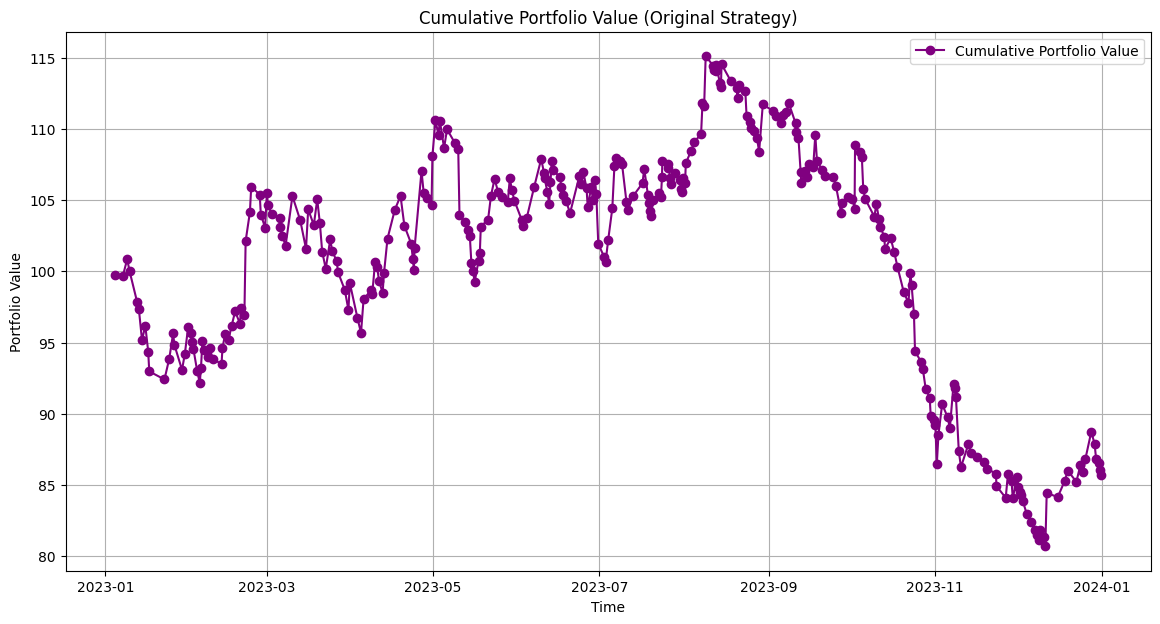


=== TESTING ALTERNATIVE STRATEGY (keyValue=4) ===
New strategy: 115 BUY signals and 97 SELL signals

=== ALTERNATIVE STRATEGY PERFORMANCE ===
=== Strategy Performance ===
Total trades: 212
Winning trades: 77 (36.32%)
Average win: 1.84%
Average loss: -1.00%
Cumulative return: 3.75%
Average trade return: 0.03%


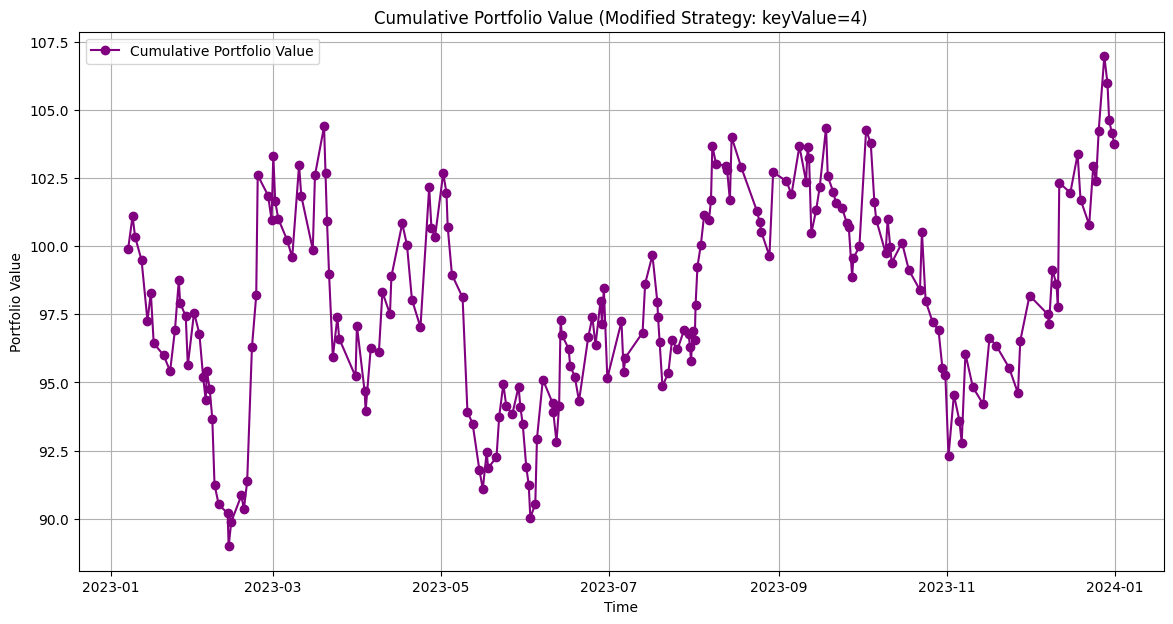


Buy & Hold Return: 156.71%


In [13]:
# --- Main Execution ---
def main():
    """Main function to execute the backtest"""
    # Set parameters
    symbol = 'BTCUSDT'
    interval = '30m'  # 30-minute intervals

    # Set date range (Jan 1, 2023 to Jan 1, 2024)
    start_date = int(datetime(2023, 1, 1, tzinfo=timezone.utc).timestamp() * 1000)
    end_date = int(datetime(2024, 1, 1, tzinfo=timezone.utc).timestamp() * 1000)

    print("Fetching Bitcoin price data from Binance Futures...")
    # Get price data using the new function
    df = get_binance_historical_data(symbol, interval, start_date, end_date)
    print(f"Retrieved {len(df)} candles from {df['timestamp'].min()} to {df['timestamp'].max()}")

    print("\nCalculating technical indicators...")
    # Calculate UT Bot with different settings
    df_ut_sell = ut_bot_minimal(df, keyValue=2.0, atrPeriod=1)    # For SELL signals
    df_ut_buy = ut_bot_minimal(df, keyValue=2.0, atrPeriod=300)   # For BUY signals

    # Add signals to main dataframe
    df['sell_signal_1'] = df_ut_sell['sell_signal']
    df['buy_signal_2'] = df_ut_buy['buy_signal']

    # Calculate STC indicator
    df_stc = compute_stc_shk(df, length=80, fast_length=27, slow_length=50, aaa=0.5)

    print("Applying trading strategy...")
    # Apply combined strategy
    df_final = apply_strategy(df_stc, stc_col='stc_shk', green_line=25, red_line=75)

    # Extract signals
    buy_signals = df_final[df_final['buy_condition'] == True]
    sell_signals = df_final[df_final['sell_condition'] == True]
    print(f"Generated {len(buy_signals)} BUY signals and {len(sell_signals)} SELL signals")

    # Simulate trades
    print("\nSimulating trades...")
    buy_trades = calculate_trades_from_signals(df_final, buy_signals, signal_type='BUY', lookback=3)
    sell_trades = calculate_trades_from_signals(df_final, sell_signals, signal_type='SELL', lookback=3)
    all_trades = pd.concat([buy_trades, sell_trades], ignore_index=True)
    all_trades.sort_values('signal_index', inplace=True)

    # Analyze performance
    print("\n=== ORIGINAL STRATEGY PERFORMANCE ===")
    performance_summary(all_trades)

    # Visualize results
    fig = plot_candlestick_with_signals(
        df_final, buy_signals, sell_signals,
        "Bitcoin Price with Trading Signals (Original Strategy)"
    )
    fig.show()

    # Plot equity curve
    plot_portfolio_value(
        all_trades, df_final, initial_value=100,
        title="Cumulative Portfolio Value (Original Strategy)"
    )

    # Test alternative strategy
    print("\n=== TESTING ALTERNATIVE STRATEGY (keyValue=4) ===")
    # Recalculate with modified parameters
    df_ut_sell_new = ut_bot_minimal(df, keyValue=4.0, atrPeriod=1)
    df['sell_signal_1_new'] = df_ut_sell_new['sell_signal']

    # Apply alternative strategy
    df_new = df.copy()
    df_new['sell_signal_1'] = df_new['sell_signal_1_new']
    df_stc_new = compute_stc_shk(df_new, length=80, fast_length=27, slow_length=50, aaa=0.5)
    df_final_new = apply_strategy(df_stc_new, stc_col='stc_shk', green_line=25, red_line=75)

    # Extract signals
    buy_signals_new = df_final_new[df_final_new['buy_condition'] == True]
    sell_signals_new = df_final_new[df_final_new['sell_condition'] == True]
    print(f"New strategy: {len(buy_signals_new)} BUY signals and {len(sell_signals_new)} SELL signals")

    # Simulate trades for new strategy
    buy_trades_new = calculate_trades_from_signals(df_final_new, buy_signals_new, signal_type='BUY')
    sell_trades_new = calculate_trades_from_signals(df_final_new, sell_signals_new, signal_type='SELL')
    all_trades_new = pd.concat([buy_trades_new, sell_trades_new], ignore_index=True)
    all_trades_new.sort_values('signal_index', inplace=True)

    # Analyze performance
    print("\n=== ALTERNATIVE STRATEGY PERFORMANCE ===")
    performance_summary(all_trades_new)

    # Visualize new strategy
    fig_new = plot_candlestick_with_signals(
        df_final_new, buy_signals_new, sell_signals_new,
        "Bitcoin Price with Trading Signals (Modified Strategy: keyValue=4)"
    )
    fig_new.show()

    # Plot equity curve for new strategy
    plot_portfolio_value(
        all_trades_new, df_final_new, initial_value=100,
        title="Cumulative Portfolio Value (Modified Strategy: keyValue=4)"
    )

    # Calculate buy & hold return for comparison
    initial_price = df['close'].iloc[0]
    final_price = df['close'].iloc[-1]
    overall_return_pct = ((final_price / initial_price) - 1) * 100
    print(f"\nBuy & Hold Return: {overall_return_pct:.2f}%")

# Run the backtest
if __name__ == "__main__":
    main()